# Did they just turn around the bus?

Here's a question for you: What happens to bus transit delays when traffic changes are made? In Trondheim, battery-electric vehicles were allowed to drive in the bus lane, until August 2024. Then, the first few days of August, new signs were made and BEVs had to relocate to the normal lane.

I would like to do an analysis of that. Using data from [Entur](https://data.entur.no/domain/public-transport-data), it should be possible to look into this. This contains data for many years for all bus lanes in the Trondheim region (and many others).

I've done a bit of boring prep-work to set this up and collected the ATB data for 2024 on [this address](https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/atb_legs.parquet). You can download it and play along if you'd like! This notebook only uses data from there, so everything should work just fine on your machine without any code changes. Just make sure to install DuckDB, seaborn and jupyter first.

I've done a bunch of cleanups too, like removing all the buses that were travelling exceedingly close to the speed of light. I've also connected each stop registration in the bus journey with the following stop registration, so we can look at driving distances on individual legs. The [code](https://github.com/kaaveland/bus-eta/blob/main/kollektivkart/etl/legs.py) for that is open source.

Let's load some data and get started.

In [1]:
import duckdb
import seaborn as sns
# Set up some styling for the visual stuff
sns.set_theme(
    style='whitegrid', rc={
        'figure.figsize': (12, 8),
        'figure.frameon': False,
        'legend.frameon': False
    }
)

db = duckdb.connect(':memory:')

%load_ext sql
%config SqlMagic.displaylimit=50
%sql db --alias duckdb
%sql set memory_limit='16GB';
%sql set threads=8;
%sql create or replace table legs as from read_parquet('https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/atb_legs.parquet')

The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

Count
36214722


Let's start by looking at the schema we have:

In [2]:
%sql describe legs;

Running query in 'duckdb'

column_name,column_type,null,key,default,extra
lineRef,VARCHAR,YES,None,None,None
dataSource,VARCHAR,YES,None,None,None
directionRef,VARCHAR,YES,None,None,None
serviceJourneyId,VARCHAR,YES,None,None,None
sequenceNr,BIGINT,YES,None,None,None
start_time,TIMESTAMP WITH TIME ZONE,YES,None,None,None
actual_duration,INTEGER,YES,None,None,None
planned_duration,INTEGER,YES,None,None,None
delay,INTEGER,YES,None,None,None
deviation,INTEGER,YES,None,None,None


For now, these are the most interesting columns for us to focus on:

- `lineRef` is an identifier for a line.
- `directionRef` indicates which direction that this particular journey travels in.
- `serviceJourneyId` is an ID of a trip. With `operatingDate`, it uniquely identifies a journey.
- `sequenceNr` is a monotonically increasing number that increases at each stop point in the journey. Ours starts at `2`, because we use the `sequenceNr` for the `to_stop` of a leg.
- `from_stop` and `to_stop` are two subsequent stop points in a journey.

In theory, we can use `lineRef` and `directionRef` to identify the route of the journey. But that's just in theory.

## Houston, we have a problem

At first, I made this assumption, and I found that I got some unexpected results. I did a little bit of digging, and identified that the _meaning_ of `directionRef` is not stable over time. I'll illustrate, don't worry.

The `lineRef` where I first identified this problem is `'ATB:Line:2_3'`, one of the lines that I frequently use to/from town. This should have 2 different directions. Let's check:

In [3]:
%%sql
from legs
select count(*) as count, directionRef
where lineRef = 'ATB:Line:2_3'
group by directionRef
order by count desc;

Running query in 'duckdb'

count,directionRef
694901,Inbound
694815,Outbound


That's nice, we have about the same amount of legs registered travelling in each direction. So we could just separate the legs into piles based on that, and start aggregating? Well, no.

This line passes from Nidarosdomen to Studentersamfundet heading one way, and from Studentersamfundet to Nidarosdomen heading in the opposite direction. Let's check which direction is which:

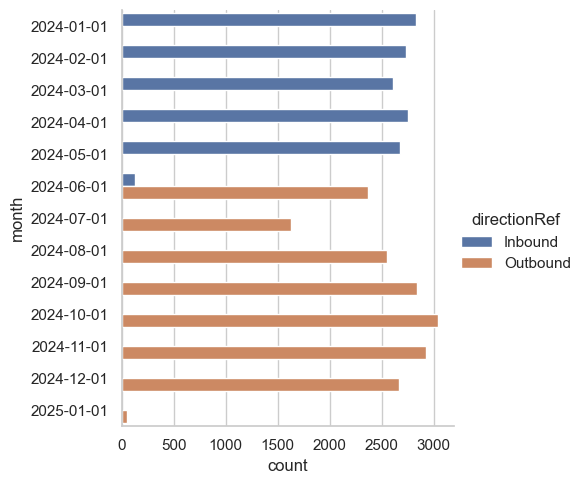

In [4]:
df = db.sql("""
from legs
select count(*) as count, directionRef, date_trunc('month', operatingDate) as month
-- For me, this is _to_ town
where
  from_stop = 'Studentersamfundet'
  and to_stop = 'Nidarosdomen'
  and lineRef = 'ATB:Line:2_3'
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='directionRef', kind='bar');

Did you see that? They just turned the directions around!

If we aggregate based on this, the meaning changes some time in the start of summer 2024. Using this for aggregations won't make much sense. It'll be like aggregating the phone book. We'll get numbers, but will anyone pick up?

So, we need to find a way to fix this. This is an important gotcha when working with data that is collected from real physical processes. It's sometimes difficult to keep track of all the assumptions we make when doing analysis. Here, it's easy to assume that `directionRef` is stable over time, but it turns out it's not. Let's zoom in a little bit on June 2024:

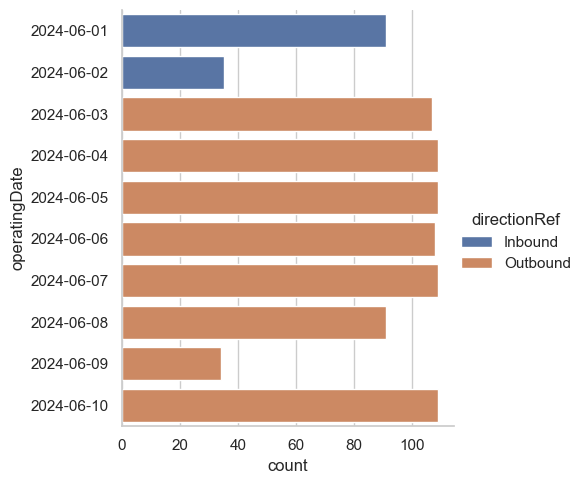

In [5]:
df = db.sql("""
from legs
select count(*) as count, directionRef, operatingDate
-- For me, this is _to_ town
where
  from_stop = 'Studentersamfundet'
  and to_stop = 'Nidarosdomen'
  and lineRef = 'ATB:Line:2_3'
  and operatingDate between '2024-06-01' and '2024-06-10'
group by all
order by operatingDate;
""").df()

sns.catplot(df, y='operatingDate', x='count', hue='directionRef', kind='bar');

But it turns out; we can probably assume that `directionRef` is consistent within one day. This means that if we could build a mapping from `lineRef, operatingDate` to some "canonical" direction, we can handle this issue. That's great news! Building that mapping is the topic of this analysis.

## A canonical what?

Since the meaning of `Inbound` can change, we need some other way to name the direction. My intuition is that we can probably use the most common origin and the most common destination with that `directionRef` on that day. Hopefully, that stays stable across time. We'll just have to find out.

We can easily use window functions to find the first and last stop of each `serviceJourneyId, operatingDate` pair. The way this works is that we define a window, which has two parts:

- A partition, or group key. The window function gets to look at every row within the same partition and do some sort of aggregation.
- We can also use a clause to bound the size of the window, and give it an ordering.

Let's do a demo with a single journey.

In [6]:
%%sql
with choice as (
    from legs
    select operatingDate, serviceJourneyId
    where lineRef = 'ATB:Line:2_3' and operatingDate = '2024-01-01'
    limit 1
)
from choice join legs using(operatingDate, serviceJourneyId)
select directionRef, sequenceNr, start_time, from_stop, to_stop
order by sequenceNr;

Running query in 'duckdb'

directionRef,sequenceNr,start_time,from_stop,to_stop
Inbound,2,2024-01-01 15:48:26+01:00,Dragvoll,Edvard Bulls veg
Inbound,3,2024-01-01 15:49:19+01:00,Edvard Bulls veg,Bergheim
Inbound,4,2024-01-01 15:50:37+01:00,Bergheim,Voll studentby
Inbound,5,2024-01-01 15:53:49+01:00,Voll studentby,Moholt studentby
Inbound,6,2024-01-01 15:55:11+01:00,Moholt studentby,Østre Berg
Inbound,7,2024-01-01 15:56:17+01:00,Østre Berg,Berg studentby
Inbound,8,2024-01-01 15:58:10+01:00,Berg studentby,Gløshaugen
Inbound,9,2024-01-01 15:59:57+01:00,Gløshaugen,Høgskoleringen
Inbound,10,2024-01-01 16:01:18+01:00,Høgskoleringen,Studentersamfundet
Inbound,11,2024-01-01 16:02:38+01:00,Studentersamfundet,Nidarosdomen


This gives us a single journey. We can tell that the origin is Dragvoll and the destination is Hallset. We can easily put this information in every row like this:

In [7]:
%%sql
with choice as (
    from legs
    select operatingDate, serviceJourneyId
    where lineRef = 'ATB:Line:2_3' and operatingDate = '2024-01-01'
    limit 1
)
from choice join legs using(operatingDate, serviceJourneyId)
select
  -- this is old
  directionRef, sequenceNr, start_time, from_stop, to_stop,
  -- new column, window function!
  min_by(from_stop, sequenceNr) over (
    partition by (operatingDate, serviceJourneyId)
  ) as origin,
  -- also a window function
  max_by(to_stop, sequenceNr) over (
    partition by (operatingDate, serviceJourneyId)
  ) as destination
order by sequenceNr;

Running query in 'duckdb'

directionRef,sequenceNr,start_time,from_stop,to_stop,origin,destination
Inbound,2,2024-01-01 15:48:26+01:00,Dragvoll,Edvard Bulls veg,Dragvoll,Hallset
Inbound,3,2024-01-01 15:49:19+01:00,Edvard Bulls veg,Bergheim,Dragvoll,Hallset
Inbound,4,2024-01-01 15:50:37+01:00,Bergheim,Voll studentby,Dragvoll,Hallset
Inbound,5,2024-01-01 15:53:49+01:00,Voll studentby,Moholt studentby,Dragvoll,Hallset
Inbound,6,2024-01-01 15:55:11+01:00,Moholt studentby,Østre Berg,Dragvoll,Hallset
Inbound,7,2024-01-01 15:56:17+01:00,Østre Berg,Berg studentby,Dragvoll,Hallset
Inbound,8,2024-01-01 15:58:10+01:00,Berg studentby,Gløshaugen,Dragvoll,Hallset
Inbound,9,2024-01-01 15:59:57+01:00,Gløshaugen,Høgskoleringen,Dragvoll,Hallset
Inbound,10,2024-01-01 16:01:18+01:00,Høgskoleringen,Studentersamfundet,Dragvoll,Hallset
Inbound,11,2024-01-01 16:02:38+01:00,Studentersamfundet,Nidarosdomen,Dragvoll,Hallset


So that's pretty neat! Come to think of it, we don't really need window functions for this, we can do this with `group by`. But I'm sure it'll come in handy later! In DuckDB, we have a `qualify` clause that we can put after `where`, which allows us to filter a row based on a window function. That's a super neat trick.

Let's make our table.

In [8]:
%%sql
create or replace table route_name as
with counts as (
  from legs
  select
    -- This is the triple we want to name / map
    operatingDate,
    lineRef,
    directionRef,
    -- These are what we'll use for naming. Maybe they're stable over time?
    min_by(from_stop, sequenceNr) as origin,
    max_by(to_stop, sequenceNr) as destination,
    -- We'll use this to rank them, picking the most common pair of origin/destination
    -- as the name for the `directionRef` on this day
    count(*) as count
  group by all -- handy shortcut to group by whatever we didn't aggregate
)
from counts
select
  operatingDate,
  lineRef,
  directionRef,
  origin,
  destination,
  count
qualify
  count = max(count) over (partition by (operatingDate, lineRef, directionRef))
;

Running query in 'duckdb'

Count
149176


Let's zoom in on June 2024 again, and check if this fixes our problem:

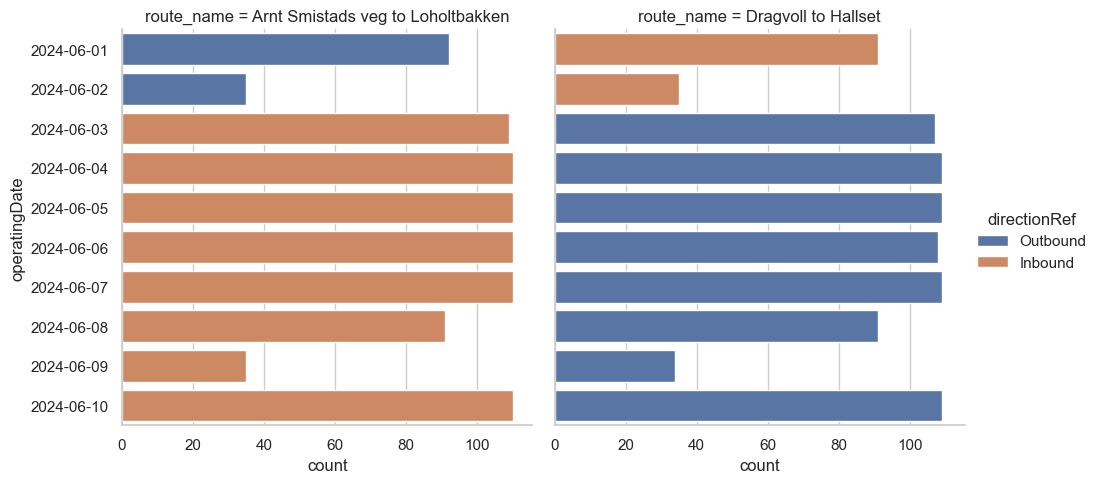

In [9]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, directionRef, operatingDate, origin || ' to ' || destination as route_name
-- For me, this is _to_ town
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_3' and operatingDate between '2024-06-01' and '2024-06-10')
group by all
order by operatingDate;
""").df()

sns.catplot(df, y='operatingDate', x='count', hue='directionRef', col='route_name', kind='bar');

Huge success! Now let's zoom back out:

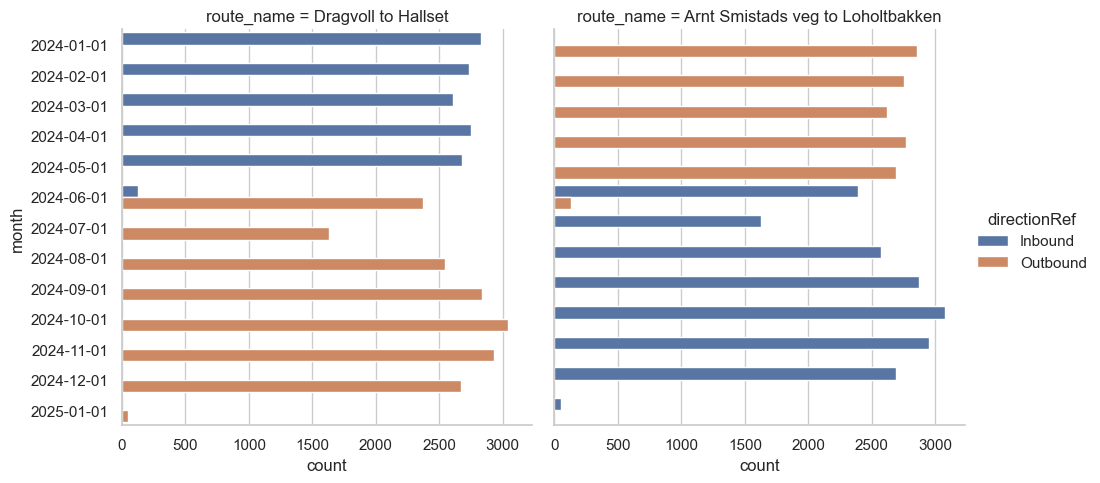

In [10]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, directionRef, date_trunc('month', operatingDate) as month, origin || ' to ' || destination as route_name
-- For me, this is _to_ town
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_3')
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='directionRef', col='route_name', kind='bar');

This appears to be stable all year. Great news! We're not entirely home-free, though. Let me show you what I mean by sampling another lineRef:

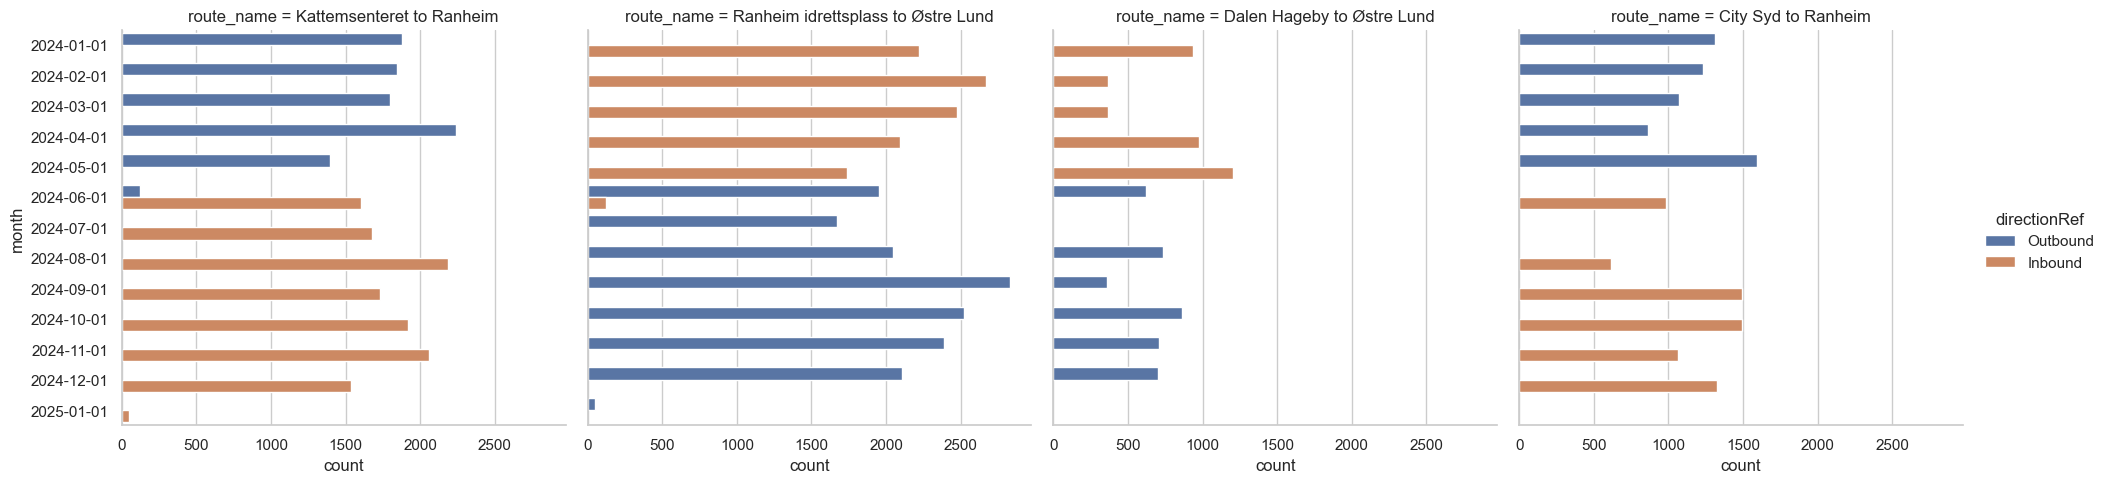

In [11]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, directionRef, date_trunc('month', operatingDate) as month, origin || ' to ' || destination as route_name
-- For me, this is _to_ town
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_1')
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='directionRef', col='route_name', kind='bar');

Oh no, this one has more variations!

Fortunately, we can fix this too! Perhaps not perfectly, but something that should be close enough. What should be sufficient is to set a permament _directionRef_ for each route name. We'll use the first directionRef for that route.

In [12]:
%%sql
create or replace table route_name as
with counts as (
  from legs
  select
    -- This is the triple we want to name / map
    operatingDate,
    lineRef,
    directionRef,
    -- These are what we'll use for naming. Maybe they're stable over time?
    min_by(from_stop, sequenceNr) as origin,
    max_by(to_stop, sequenceNr) as destination,
    -- We'll use this to rank them, picking the most common pair of origin/destination
    -- as the name for the `directionRef` on this day
    count(*) as count
  group by all -- handy shortcut to group by whatever we didn't aggregate
)
from counts
select
  operatingDate,
  lineRef,
  directionRef,
  -- Changed this! We'll propagate the first directionRef seen for this line/origin/destination
  -- to all of eternity
  min_by(directionRef, operatingDate) over (partition by (lineRef, origin, destination)) as canonical_direction,
  origin,
  destination,
  count
qualify
  count = max(count) over (partition by (operatingDate, lineRef, directionRef))

Running query in 'duckdb'

Count
149176


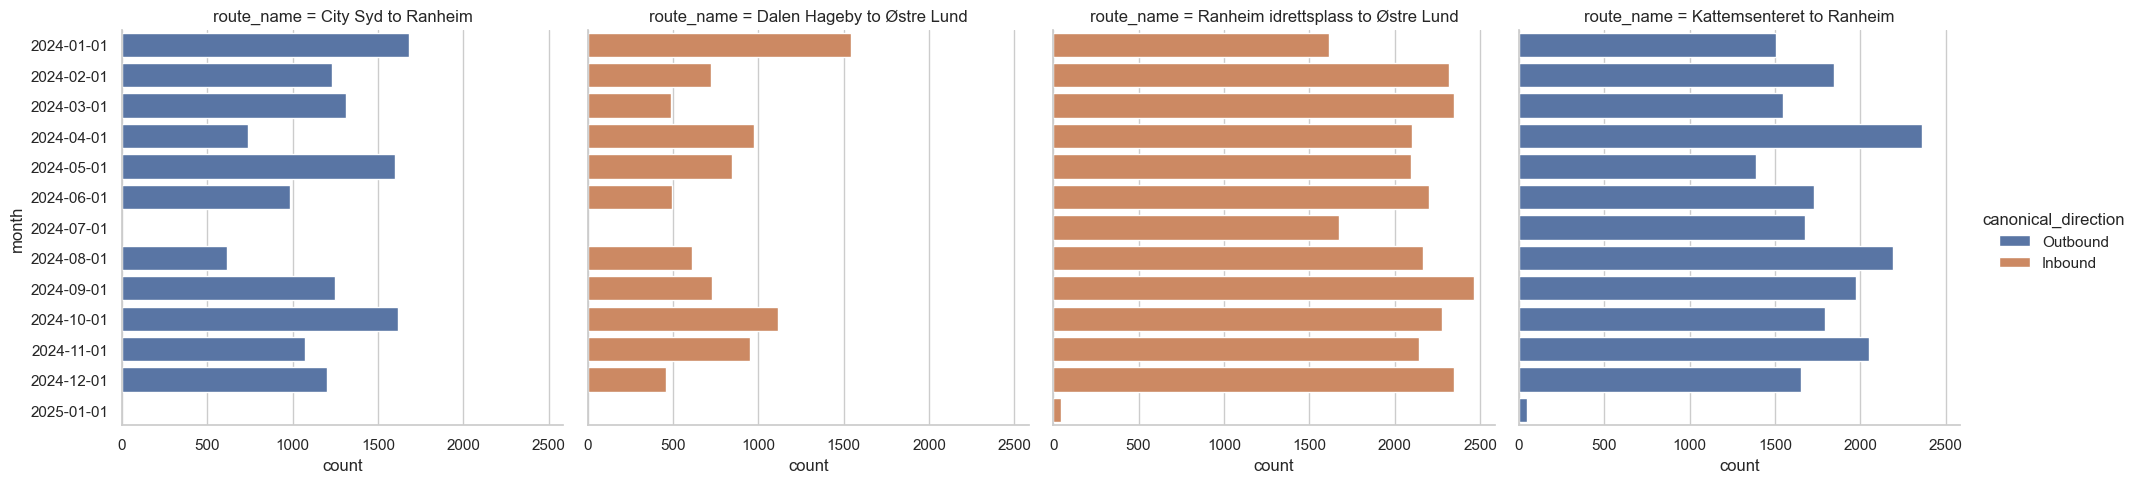

In [13]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, date_trunc('month', operatingDate) as month, canonical_direction, origin || ' to ' || destination as route_name
-- For me, this is _to_ town
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_1')
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='canonical_direction', col='route_name', kind='bar');

And that's it, now we have perfect separation! Now I just need to write a job that will take care of this in the future.

Later on, I might find an edge-case where this won't work, but this should deal with the noisiest part of the data for my use case.

Thanks for reading, hope you found it interesting!